## 뉴스 기사 자동 분류

## TF-IDF
- BoW : 문장에 어떤 단어가 어떤 빈도로 사용되는지 확인하는 방법
- TF-IDF : 문장 전체에서 단어가 어느 정도의 중요도를 갖는지 고려
- $\text{TF-IDF} = tf(t, d) \times idf(t)$
    - tf : 문서 내부의 단어 출현 빈도
- $idf(t) = \log \dfrac{|D|}{df(d, t)}$ : 모든 문서 내부의 단어 출현 빈도
    - df : 단어 t를 포함한 문서의 수, D : 문서의 총 수

### TF-IDF 모듈 만들기
- `tfidf.py`  

```python
from konlpy.tag import Okt
import pickle
import numpy as np

# Okt 객체 초기화
okt = Okt()

# 전역 변수
word_dic = {'_id': 0} # 단어 사전
dt_dic = {} # 문장 전체에서의 단어 출현 횟수
files = [] # 문서들을 저장할 리스트

def tokenize(text):
    ''' KoNLPy로 형태소 분석하기 '''
    result = []
    word_s = okt.pos(text, norm=True, stem=True)
    for n, h in word_s:
        if not (h in ['Noun', 'Verb', 'Adjective']):continue
        if h == 'Punctuation' and h == 'Number': continue
        result.append(n)
    return result

def words_to_ids(words, auto_add=True):
    ''' 단어를 ID로 변환하기 '''
    result = []
    for w in words:
        if w in word_dic:
            result.append(word_dic[w])
            continue
        elif auto_add:
            id = word_dic[w] = word_dic['_id']
            word_dic['_id'] += 1
            result.append(id)
    return result

def add_text(text):
    ''' 텍스트를 ID 리스트로 변환해서 추가하기 '''
    ids = words_to_ids(tokenize(text))
    files.append(ids)

def add_file(path):
    ''' 텍스트 파일을 학습 전용으로 추가하기 '''
    with open(path, 'r', encoding='utf8') as f:
        s = f.read()
        add_text(s)
        
def calc_files():
    ''' 추가한 파일 계산하기 '''
    global dt_dic
    result = []
    doc_count = len(files)
    dt_dic = {}
    # 단어 출현 횟수 세기
    for words in files:
        used_word = {}
        data = np.zeros(word_dic['_id'])
        for id in words:
            data[id] += 1
            used_word[id] = 1
            
        # 단어 t가 사용되고 있을 경우 dt_dic의 수를 1 더하기
        for id in used_word:
            if not (id in dt_dic) : dt_dic[id] = 0
            dt_dic[id] += 1
        
        # 정규화하기
        data = data / len(words)
        result.append(data)
        
    # TF-IDF 계산하기
    for i, doc in enumerate(result):
        for id, v in enumerate(doc):
            idf = np.log(doc_count / dt_dic[id])
            doc[id] = min([doc[id] * idf, 1.0])
        result[i] = doc
    return result

def save_dic(fname):
    ''' 사전을 파일로 저장하기 '''
    pickle.dump(
            [word_dic, dt_dic, files],
            open(fname, 'wb'))
    
def load_dic(fname):
    ''' 사전 파일 읽어 들이기 '''
    global word_dic, dt_dic, files
    n = pickle.load(open(fname, 'rb'))
    word_dic, dt_dic, files = n

def calc_text(text):
    ''' 문장을 벡터로 변환하기 '''
    data = np.zeros(word_dic['_id'])
    words = words_to_ids(tokenize(text), False)
    for w in words:
        data[w] += 1
    data = data / len(words)
    for id, v in enumerate(data):
        idf = np.log(len(files) / dt_dic[id]) + 1
        data[id] = min([data[id] * idf, 1.0])
    return data

# 모듈 테스트
if __name__ == '__main__':
    add_text('비')
    add_text('오늘은 비가 내렸어요.')
    add_text('오늘은 더웠지만 오후부터 비가 내렸다.')
    add_text('비가 내리는 일요일이다.')
    print(calc_files())
    print(word_dic)
```

output  
[array([0., 0., 0., 0., 0., 0.]), array([0.        , 0.23104906, 0.09589402, 0.        , 0.        ,  
       0.        ]), array([0.        , 0.13862944, 0.05753641, 0.27725887, 0.27725887,  
       0.        ]), array([0.        , 0.        , 0.09589402, 0.        , 0.        ,  
       0.46209812])]  
{'_id': 6, '비': 0, '오늘': 1, '내리다': 2, '덥다': 3, '오후': 4, '일요일': 5}  

### 텍스트 분류하기
1. 텍스트에서 불필요한 품사 제거
2. 사전을 기반으로 단어를 숫자로 변환
3. 파일 내부 단어 출현 비율 계산
4. 데이터 학습

In [2]:
import os, glob, pickle
import tfidf

# 변수 초기화
y = []
x = []

# 디렉터리 내부의 파일 목록 전체에 대해 처리
def read_files(path, label):
    print('read_files=', path)
    files = glob.glob(path+'/*.txt')
    for f in files:
        tfidf.add_file(f)
        y.append(label)

# 기사를 넣은 디렉터리 읽어 들이기
read_files('../datasets/text/100', 0)
read_files('../datasets/text/101', 1)
read_files('../datasets/text/103', 2)
read_files('../datasets/text/105', 3)

# TF-IDF 벡터로 변환
x = tfidf.calc_files()

# 저장
pickle.dump([y, x], open('../datasets/text/genre.pickle', 'wb'))
tfidf.save_dic('../datasets/text/genre-tfidf.dic')
print('ok')

read_files= ../datasets/text/100
read_files= ../datasets/text/101
read_files= ../datasets/text/103
read_files= ../datasets/text/105
ok


### TF-IDF를 나이브 베이즈로 학습시키기

In [3]:
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np

# TF-IDF 데이터베이스 읽어들이기]
data = pickle.load(open('../datasets/text/genre.pickle', 'rb'))
y = data[0]
x = data[1]

# train, test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 학습
model = GaussianNB()
model.fit(x_train, y_train)

# 평가
y_pred = model.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
rep = metrics.classification_report(y_test, y_pred)

print('정답률 :', acc)
print(rep)

정답률 : 0.8328125
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       156
           1       0.85      0.66      0.75       146
           2       0.79      0.90      0.84       179
           3       0.81      0.81      0.81       159

    accuracy                           0.83       640
   macro avg       0.84      0.83      0.83       640
weighted avg       0.84      0.83      0.83       640



## 딥러닝으로 정답률 개선하기

### scikit-learn에서 딥러닝으로 변경하기
- 주의 사항
    1. 레이블 데이터를 one-hot 형식으로 변환
    2. 입력과 출력 벡터 크기를 확실하게 확인해서 지정

In [3]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [9]:
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np

# 분류할 레이블 수
n_classes = 4

# 데이터베이스 읽어 들이기
data = pickle.load(open('../datasets/text/genre.pickle', 'rb'))
y = data[0]
x = data[1]

# 레이블 OHE 변환
y = keras.utils.to_categorical(y, n_classes)
in_size = x[0].shape[0]

# train, test split
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.2)

In [6]:
# MLP 모델 정의
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size, )))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

In [7]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(), metrics=['accuracy'])

In [10]:
# 학습
hist = model.fit(x_train, y_train, batch_size=128,
                epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
20/20 [==============================] - 1s 30ms/step - loss: 0.9314 - accuracy: 0.7133 - val_loss: 0.4573 - val_accuracy: 0.8703
Epoch 2/20
20/20 [==============================] - 0s 19ms/step - loss: 0.2755 - accuracy: 0.9183 - val_loss: 0.3576 - val_accuracy: 0.8766
Epoch 3/20
20/20 [==============================] - 0s 20ms/step - loss: 0.1232 - accuracy: 0.9636 - val_loss: 0.3517 - val_accuracy: 0.8844
Epoch 4/20
20/20 [==============================] - 0s 19ms/step - loss: 0.0539 - accuracy: 0.9859 - val_loss: 0.3765 - val_accuracy: 0.8875
Epoch 5/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0237 - accuracy: 0.9949 - val_loss: 0.4187 - val_accuracy: 0.8813
Epoch 6/20
20/20 [==============================] - 0s 19ms/step - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.4272 - val_accuracy: 0.8875
Epoch 7/20
20/20 [==============================] - 0s 19ms/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.4729 - val_accuracy: 0.8859
Epoch 8/20
20

In [11]:
# 평가
score = model.evaluate(x_test, y_test, verbose=1)

20/20 [==============================] - 0s 3ms/step - loss: 0.7860 - accuracy: 0.8953


In [12]:
# 가중치 데이터 저장하기
model.save_weights('../models/genre_model.hdf5')

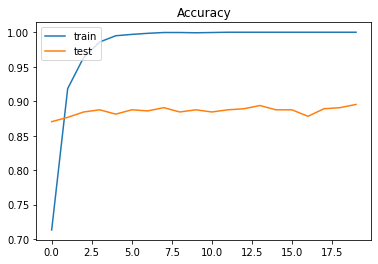

In [13]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 직접 문장을 지정해 판정하기
- 이후 04장을 위해 `my_text.py`로 저장

In [14]:
import pickle, tfidf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import model_from_json

# 텍스트
text1 = '''
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
'''

text2 = '''
아이폰과 아이패드 모두 가지고 다니므로 USB를 2개 연결할 수 있는 휴대용 배터리를 선호합니다.
'''

text3 = '''
이번 주에는 미세먼지가 많을 것으로 예상되므로 노약자는 외출을 자제하는 것이 좋습니다.
'''

# TF-IDF 사전 읽어 들이기
tfidf.load_dic('../datasets/text/genre-tfidf.dic')

# Keras 모델 정의, 가중치 데이터 읽기
n_classes = 4
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(37414, )))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(), metrics=['accuracy'])
model.load_weights('../models/genre_model.hdf5')

In [15]:
# 텍스트 지정해서 판별
def check_genre(text):
    # 레이블 정의
    LABELS = ['정치', '경제', '생활', 'IT/과학']
    # TF-IDF 벡터 변환
    data = tfidf.calc_text(text)
    # MLP로 예측
    pre = model.predict(np.array([data]))[0]
    n = pre.argmax()
    print(LABELS[n], '(', pre[n], ')')
    return LABELS[n], float(pre[n]), int(n)

In [16]:
check_genre(text1)
check_genre(text2)
check_genre(text3)

정치 ( 1.0 )
IT/과학 ( 1.0 )
생활 ( 0.99994946 )


('생활', 0.9999494552612305, 2)